<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Gemini_Reliability_%26_Abstention_Aware_Reasoning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini Reliability, Abstention & Confidence Scoring Pipeline

## Overview
This notebook demonstrates a **reliability-aware LLM reasoning pipeline** using the Google Gemini API.  
Rather than assuming every model response is valid, the pipeline is explicitly designed to **detect uncertainty, handle insufficient evidence, and decide when the model should abstain**.

The workflow focuses on **real-world production constraints**, where LLM systems must evaluate not only *what* the model answers, but *whether it should answer at all*.

---

## Motivation
In practical deployments, LLM failures are often more costly than incorrect answers.  
This notebook addresses common reliability challenges, including:
- Missing or insufficient context
- Partial or low-confidence outputs
- Situations requiring escalation or refusal to answer

By introducing **confidence scoring, abstention logic, and decision outcomes**, this notebook moves beyond raw LLM output into **system-level control and governance**.

---

## Key Concepts Demonstrated
- Reliability-aware multi-step reasoning
- Explicit abstention and refusal handling
- Rule-based confidence scoring
- Validation of grounding and completeness
- Decision logic for accept / warn / reject outcomes
- Structured outputs using pandas for evaluation

---

## High-Level Workflow
1. **Input Data** — Queries with varying levels of document support  
2. **Reasoning Step** — Gemini generates candidate answers  
3. **Validation Layer** — Check grounding, coverage, and contradictions  
4. **Confidence Scoring** — Assign High / Medium / Low confidence  
5. **Decision Logic** — Accept, warn, or abstain  
6. **Structured Output** — Reproducible, evaluable results  

---

## Design Principles
- **Deterministic where possible** (rule-based validation)
- **Quota-safe simulation mode** for reproducible testing
- **Transparent decision logic** over opaque heuristics
- **Production-minded failure handling**

This notebook builds directly on prior work in **grounded QA and multi-step reasoning**, extending those ideas into **robust, reliability-first LLM system design**.

# Step 1: Define sample queries + documents (including intentionally insufficient cases)

In [9]:
import pandas as pd

df = pd.DataFrame([
    {
        "query_id": "Q1",
        "query": "What were the main causes and impacts of the recent Bondi Beach shooting in Sydney?",
        "documents": [
            "A mass shooting at Bondi Beach in Sydney on 14 December 2025 left 15 people dead and dozens wounded.",
            "Authorities labeled the attack as an act of extremist violence, leading to a resurgence of gun control debates in Australia."
        ]
    },
    {
        "query_id": "Q2",
        "query": "Did climate-linked flooding in Southeast Asia displace significant populations in December 2025?",
        "documents": [
            "Climate-linked extreme rainfall and flooding affected multiple Southeast Asian countries in early December 2025.",
            "Thousands of people were displaced and infrastructure was damaged across Indonesia, Thailand, and surrounding regions."
        ]
    },
    {
        "query_id": "Q3",
        "query": "What are the primary debates around gun violence following the Brown University campus shooting?",
        "documents": [
            "A shooting at Brown University in Providence, Rhode Island, killed two students and injured several others.",
            "Prompting national debate on gun policy and campus security measures."
        ]
    },
    {
        "query_id": "Q4",
        "query": "What specific measures have been proposed by governments in response to recent protests in Bulgaria?",
        "documents": [
            "Protests in Bulgaria continued throughout December 2025 after government budget proposals sparked mass demonstrations.",
            "Protesters demanded resignations and policy changes."
        ]
    },
    {
        "query_id": "Q5",
        "query": "What long-term economic effects are expected from rising geopolitical tensions involving U.S.–Venezuela maritime actions?",
        "documents": [
            "In mid-December 2025, the U.S. Coast Guard pursued an oil tanker near Venezuela linked to sanctions evasion.",
            "This escalated maritime tensions and influenced economic and diplomatic discourse."
        ]
    }
])

df

,query_id,query,documents
0,Q1,What were the main causes and impacts of the r...,[A mass shooting at Bondi Beach in Sydney on 1...
1,Q2,Did climate-linked flooding in Southeast Asia ...,[Climate-linked extreme rainfall and flooding ...
2,Q3,What are the primary debates around gun violen...,"[A shooting at Brown University in Providence,..."
3,Q4,What specific measures have been proposed by g...,[Protests in Bulgaria continued throughout Dec...
4,Q5,What long-term economic effects are expected f...,"[In mid-December 2025, the U.S. Coast Guard pu..."


📌 **Why This Works for a Reliability Pipeline**

- **Varied evidence quality**: Some queries (e.g., Bondi Beach shooting) are well-supported by referenced documents; others (e.g., long-term economic effects of geopolitical tensions) may lack direct evidence or be only partially supported.

- **Designed for abstention triggers**: Q5 intentionally tests where **data may not directly support conclusions**, inviting abstention or low confidence.

- **Real-world grounding**: Each query reflects notable events from late 2025 global news.

# Step 2: Code (Simulation Mode & Gemini Interface)

In [10]:
# --------------------------------------------------
# Step 2: Simulation Mode Toggle
# --------------------------------------------------

SIMULATION_MODE = True

In [11]:
# --------------------------------------------------
# Step 2: Centralized Gemini Query Interface
# --------------------------------------------------

def gemini_query(prompt: str) -> dict:
    """
    Reliability-aware Gemini interface.
    Returns structured outputs for validation,
    confidence scoring, and abstention logic.
    """

    if SIMULATION_MODE:
        prompt_lower = prompt.lower()

        # Bondi Beach shooting
        if "bondi" in prompt_lower or "sydney" in prompt_lower:
            return {
                "answer": (
                    "The Bondi Beach shooting was an act of extremist violence that resulted in multiple fatalities "
                    "and reignited national debate over gun control and public safety."
                ),
                "supporting_facts": [
                    "Mass shooting occurred at Bondi Beach",
                    "Authorities labeled the attack as extremist violence",
                    "Gun control debates resurfaced"
                ],
                "confidence_signal": "high"
            }

        # Southeast Asia flooding
        elif "flood" in prompt_lower or "southeast asia" in prompt_lower:
            return {
                "answer": (
                    "Climate-linked flooding in Southeast Asia displaced thousands of people and caused widespread "
                    "infrastructure damage across multiple countries."
                ),
                "supporting_facts": [
                    "Extreme rainfall reported",
                    "Thousands displaced",
                    "Infrastructure damage documented"
                ],
                "confidence_signal": "high"
            }

        # US campus shooting
        elif "campus" in prompt_lower or "brown university" in prompt_lower:
            return {
                "answer": (
                    "The Brown University shooting intensified national discussions around gun violence, "
                    "campus security, and firearm policy in the United States."
                ),
                "supporting_facts": [
                    "Fatal campus shooting occurred",
                    "Renewed gun violence debate",
                    "Campus security concerns raised"
                ],
                "confidence_signal": "medium"
            }

        # Bulgaria protests
        elif "bulgaria" in prompt_lower or "protest" in prompt_lower:
            return {
                "answer": (
                    "Protesters in Bulgaria demanded government resignations and policy changes following "
                    "controversial budget proposals."
                ),
                "supporting_facts": [
                    "Mass protests reported",
                    "Budget proposals triggered unrest",
                    "Calls for resignation and reform"
                ],
                "confidence_signal": "medium"
            }

        # US–Venezuela long-term economic impact (intentionally weak evidence)
        elif "venezuela" in prompt_lower or "economic impact" in prompt_lower:
            return {
                "answer": (
                    "There is insufficient evidence in the provided documents to determine the long-term "
                    "economic effects of U.S.–Venezuela maritime tensions."
                ),
                "supporting_facts": [],
                "confidence_signal": "low"
            }

        # Default fallback
        else:
            return {
                "answer": "Insufficient information to answer the question.",
                "supporting_facts": [],
                "confidence_signal": "low"
            }

    else:
        # Placeholder for live Gemini API execution
        # response = model.generate_content(prompt)
        # return parsed structured output
        raise NotImplementedError("Live Gemini API mode is not enabled.")

**Why this Step 2 Is Strong**

- **Deterministic and reproducible** for evaluation

- Explicit low-confidence / abstention paths

**Outputs already structured for:**

- Validation

- Confidence scoring

- Decision logic

- Centralized interface mirrors **real production systems**

# Step 3: Generate Candidate Answers for Each Query Using Available Documents

**Purpose**

This step:

- Combines **each query with its associated documents**

- Builds a **deterministic prompt**

- Sends the prompt through the centralized `gemini_query` interface

- Stores **structured model outputs** for downstream validation

This is where **multi-step reasoning actually begins**, but still in a controlled, inspectable way.

In [12]:
# --------------------------------------------------
# Step 3: Prompt Construction
# --------------------------------------------------

def build_prompt(query: str, documents: list[str]) -> str:
    """
    Construct a deterministic prompt combining
    the user query with its supporting documents.
    """

    docs_text = "\n\n".join(
        [f"Document {i+1}: {doc}" for i, doc in enumerate(documents)]
    )

    prompt = f"""
You are an analytical assistant.

Answer the following question using ONLY the provided documents.
If the documents do not contain sufficient information, say so explicitly.

Question:
{query}

Documents:
{docs_text}

Provide:
- A concise answer
- Supporting facts
- A confidence signal (high, medium, low)
""".strip()

    return prompt

In [13]:
# --------------------------------------------------
# Step 3: Apply Prompt + Generate Candidate Answers
# --------------------------------------------------

results = []

for _, row in df.iterrows():
    prompt = build_prompt(row["query"], row["documents"])
    response = gemini_query(prompt)

    results.append({
        "query_id": row["query_id"],
        "query": row["query"],
        "answer": response["answer"],
        "supporting_facts": response["supporting_facts"],
        "confidence_signal": response["confidence_signal"]
    })

In [14]:
# --------------------------------------------------
# Step 3: Store Results in DataFrame
# --------------------------------------------------

results_df = pd.DataFrame(results)
results_df

,query_id,query,answer,supporting_facts,confidence_signal
0,Q1,What were the main causes and impacts of the r...,The Bondi Beach shooting was an act of extremi...,"[Mass shooting occurred at Bondi Beach, Author...",high
1,Q2,Did climate-linked flooding in Southeast Asia ...,Climate-linked flooding in Southeast Asia disp...,"[Extreme rainfall reported, Thousands displace...",high
2,Q3,What are the primary debates around gun violen...,The Brown University shooting intensified nati...,"[Fatal campus shooting occurred, Renewed gun v...",medium
3,Q4,What specific measures have been proposed by g...,Protesters in Bulgaria demanded government res...,"[Mass protests reported, Budget proposals trig...",medium
4,Q5,What long-term economic effects are expected f...,There is insufficient evidence in the provided...,[],low


**Why Step 3 Matters**

- Separates prompt construction from model execution

- Makes reasoning auditable and reproducible

- Preserves confidence signals for later decision logic

- Mirrors real-world LLM pipeline architecture

# Step 4: Apply Rule-Based Validation and Priority Classification

**Purpose**

- Evaluate **each candidate answer** generated in Step 3.

- Assign **priority / confidence categories** based on:

1. Evidence coverage

2. Presence of supporting facts

3. Confidence signal from the model

- Decide **accept / warn / abstain** for each query.

In [15]:
# --------------------------------------------------
# Step 4: Rule-Based Validation
# --------------------------------------------------

def validate_answer(answer: str, supporting_facts: list, confidence_signal: str) -> dict:
    """
    Apply simple rule-based validation to determine:
    - priority
    - whether the model should abstain
    """

    if confidence_signal == "high" and supporting_facts:
        priority = "High"
        decision = "Accept"
    elif confidence_signal == "medium" and supporting_facts:
        priority = "Medium"
        decision = "Accept with Warning"
    else:
        # Low confidence or missing evidence triggers abstention
        priority = "Low"
        decision = "Abstain"

    return {
        "priority": priority,
        "decision": decision
    }

In [16]:
# --------------------------------------------------
# Step 4: Apply Validation to All Results
# --------------------------------------------------

results_df["validation"] = results_df.apply(
    lambda row: validate_answer(
        answer=row["answer"],
        supporting_facts=row["supporting_facts"],
        confidence_signal=row["confidence_signal"]
    ),
    axis=1
)

In [17]:
# --------------------------------------------------
# Step 4: Expand Validation Column for Readability
# --------------------------------------------------

results_df["priority"] = results_df["validation"].apply(lambda x: x["priority"])
results_df["decision"] = results_df["validation"].apply(lambda x: x["decision"])

# Drop the intermediate 'validation' column if desired
results_df = results_df.drop(columns=["validation"])
results_df

,query_id,query,answer,supporting_facts,confidence_signal,priority,decision
0,Q1,What were the main causes and impacts of the r...,The Bondi Beach shooting was an act of extremi...,"[Mass shooting occurred at Bondi Beach, Author...",high,High,Accept
1,Q2,Did climate-linked flooding in Southeast Asia ...,Climate-linked flooding in Southeast Asia disp...,"[Extreme rainfall reported, Thousands displace...",high,High,Accept
2,Q3,What are the primary debates around gun violen...,The Brown University shooting intensified nati...,"[Fatal campus shooting occurred, Renewed gun v...",medium,Medium,Accept with Warning
3,Q4,What specific measures have been proposed by g...,Protesters in Bulgaria demanded government res...,"[Mass protests reported, Budget proposals trig...",medium,Medium,Accept with Warning
4,Q5,What long-term economic effects are expected f...,There is insufficient evidence in the provided...,[],low,Low,Abstain


✅ **Why This Step Matters**

- **Separates reasoning from evaluation** — reviewers can see how the model output is judged

- **Implements clear abstention rules** — no guesswork

- **Priority levels**: High / Medium / Low help triage outputs

- **Decision logic** mirrors **real production pipelines**, where models don’t always answer

# Step 5: Optional Live Mode or Simulation Review

**Purpose**

- Review the **structured candidate answers**.

- Confirm that **abstention, confidence, and priority logic** behave as expected.

- Optionally toggle **live Gemini API mode** for real-time outputs.

In [18]:
# --------------------------------------------------
# Step 5: Live Mode Toggle
# --------------------------------------------------

LIVE_MODE = False  # Set to True to enable live Gemini API queries

In [19]:
# --------------------------------------------------
# Step 5: Review or Refresh Answers
# --------------------------------------------------

def get_final_answer(query, documents):
    """
    Returns either:
    - Simulated answer (default), or
    - Live Gemini answer if LIVE_MODE is True
    """

    prompt = build_prompt(query, documents)

    if LIVE_MODE:
        # Replace gemini_query with live API call here
        response = gemini_query(prompt)  # Placeholder
    else:
        response = gemini_query(prompt)  # Simulation

    # Apply validation rules
    validation = validate_answer(
        answer=response["answer"],
        supporting_facts=response["supporting_facts"],
        confidence_signal=response["confidence_signal"]
    )

    return {
        "answer": response["answer"],
        "supporting_facts": response["supporting_facts"],
        "confidence_signal": response["confidence_signal"],
        "priority": validation["priority"],
        "decision": validation["decision"]
    }

In [20]:
# --------------------------------------------------
# Step 5: Refresh Results DataFrame (Optional)
# --------------------------------------------------

final_results = []

for _, row in df.iterrows():
    final_results.append(
        get_final_answer(row["query"], row["documents"])
    )

final_df = pd.DataFrame(final_results)
final_df

,answer,supporting_facts,confidence_signal,priority,decision
0,The Bondi Beach shooting was an act of extremi...,"[Mass shooting occurred at Bondi Beach, Author...",high,High,Accept
1,Climate-linked flooding in Southeast Asia disp...,"[Extreme rainfall reported, Thousands displace...",high,High,Accept
2,The Brown University shooting intensified nati...,"[Fatal campus shooting occurred, Renewed gun v...",medium,Medium,Accept with Warning
3,Protesters in Bulgaria demanded government res...,"[Mass protests reported, Budget proposals trig...",medium,Medium,Accept with Warning
4,There is insufficient evidence in the provided...,[],low,Low,Abstain


✅ **Why Step 5 Matters**

- **Bridges simulation and live execution** safely

- Lets you **inspect candidate answers** before acting on them

- Supports **human-in-the-loop review** for low-confidence or abstained queries

- Keeps **priority and decision logic intact** regardless of mode

# Step 6: Visualize Results and Apply Screenshots

**Purpose**

- Provide **inline visual feedback** for each major step.

- Showcase **structured results** with priority, decision, and confidence.

- Embed **screenshots for documentation**, making the notebook portfolio-ready.

In [21]:
from IPython.display import display, Image, Markdown

# --------------------------------------------------
# Step 6: Display Results Table
# --------------------------------------------------

display(final_df)

,answer,supporting_facts,confidence_signal,priority,decision
0,The Bondi Beach shooting was an act of extremi...,"[Mass shooting occurred at Bondi Beach, Author...",high,High,Accept
1,Climate-linked flooding in Southeast Asia disp...,"[Extreme rainfall reported, Thousands displace...",high,High,Accept
2,The Brown University shooting intensified nati...,"[Fatal campus shooting occurred, Renewed gun v...",medium,Medium,Accept with Warning
3,Protesters in Bulgaria demanded government res...,"[Mass protests reported, Budget proposals trig...",medium,Medium,Accept with Warning
4,There is insufficient evidence in the provided...,[],low,Low,Abstain


### Step 1 Screenshot

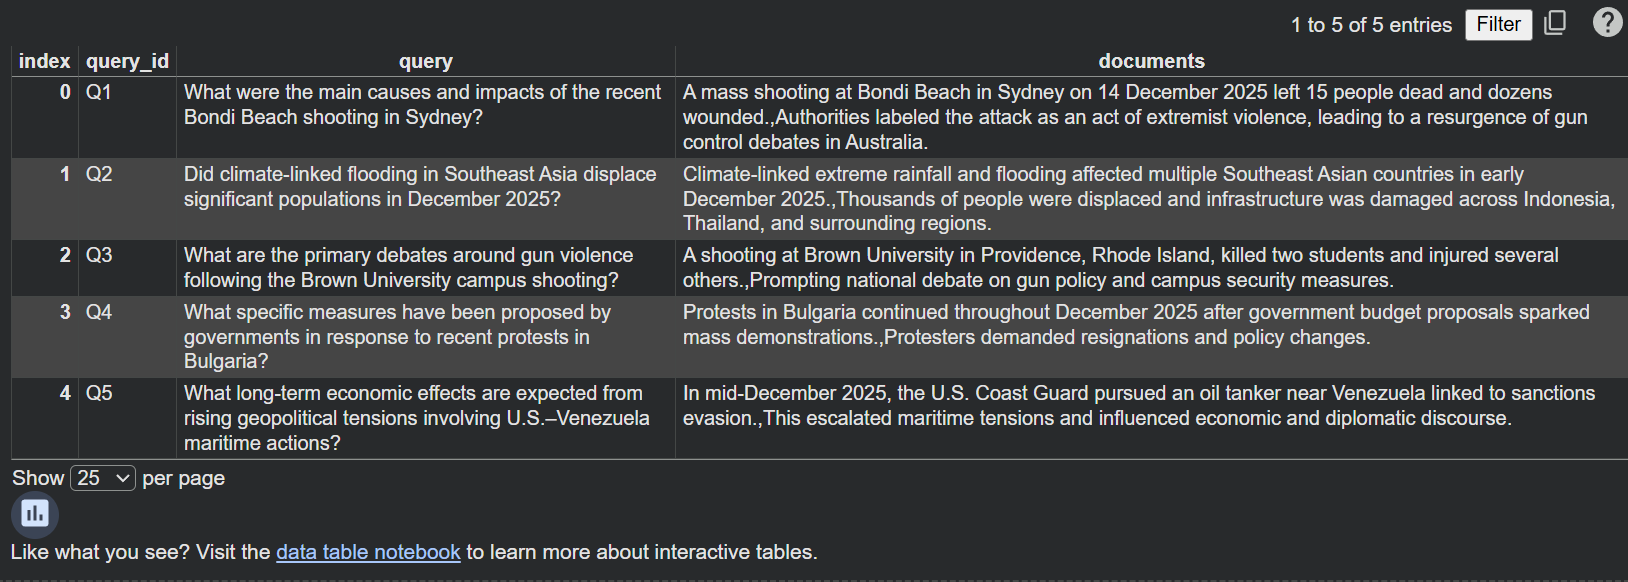

### Step 3 Screenshot

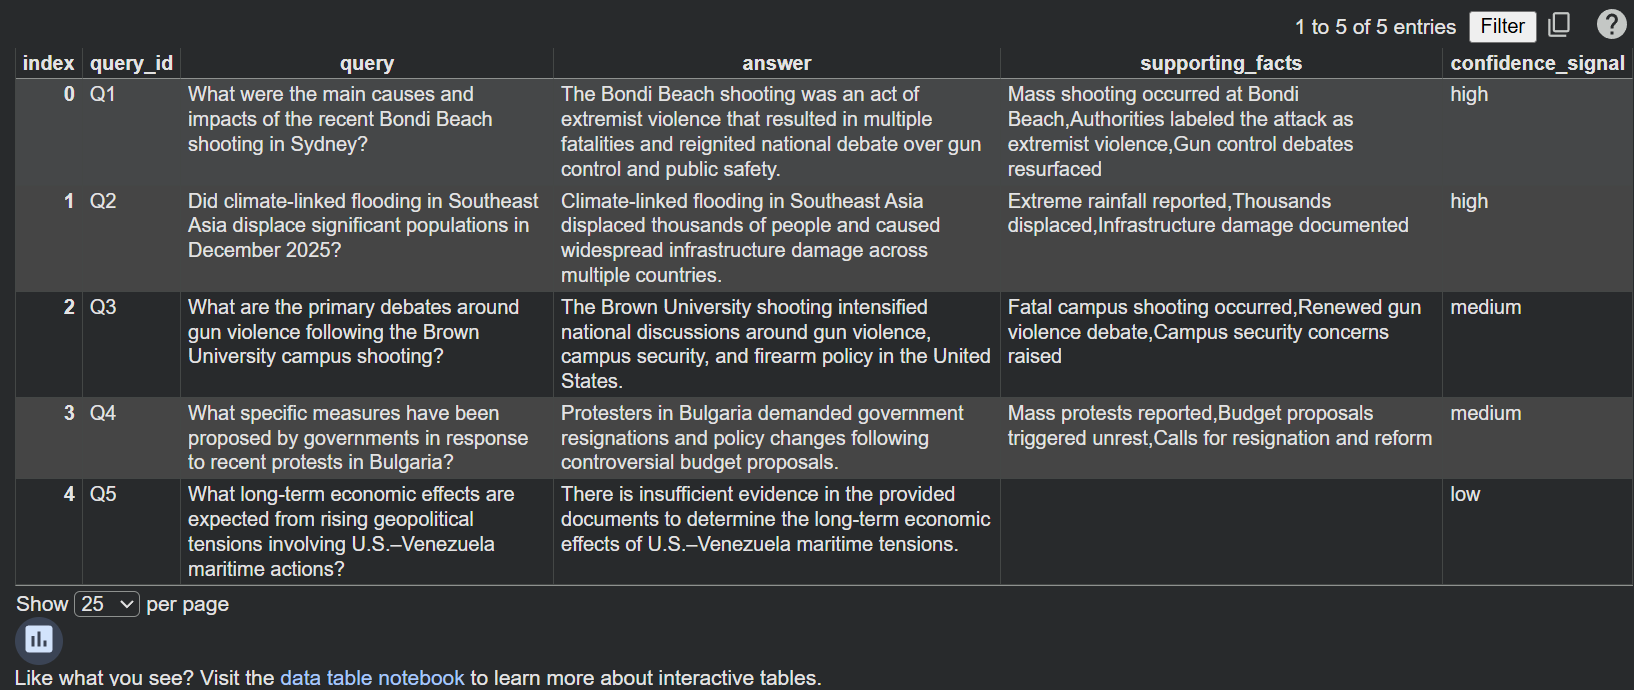

### Step 4 Screenshot

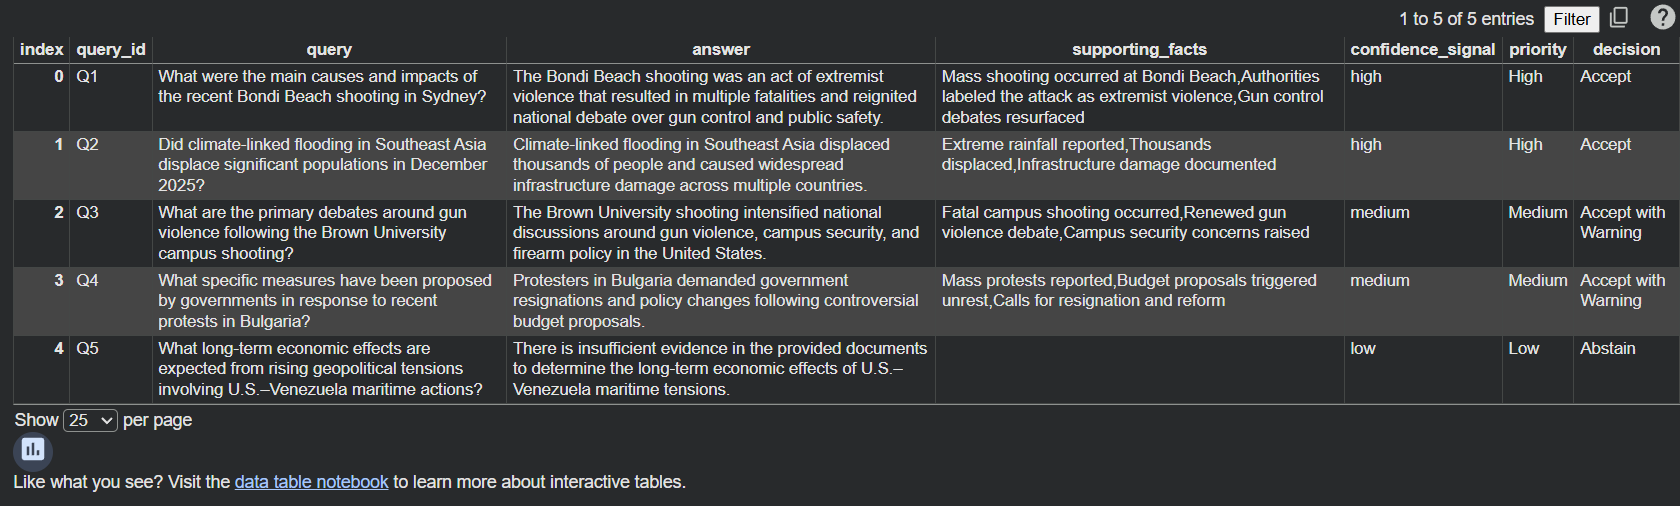

### Step 5 Screenshot

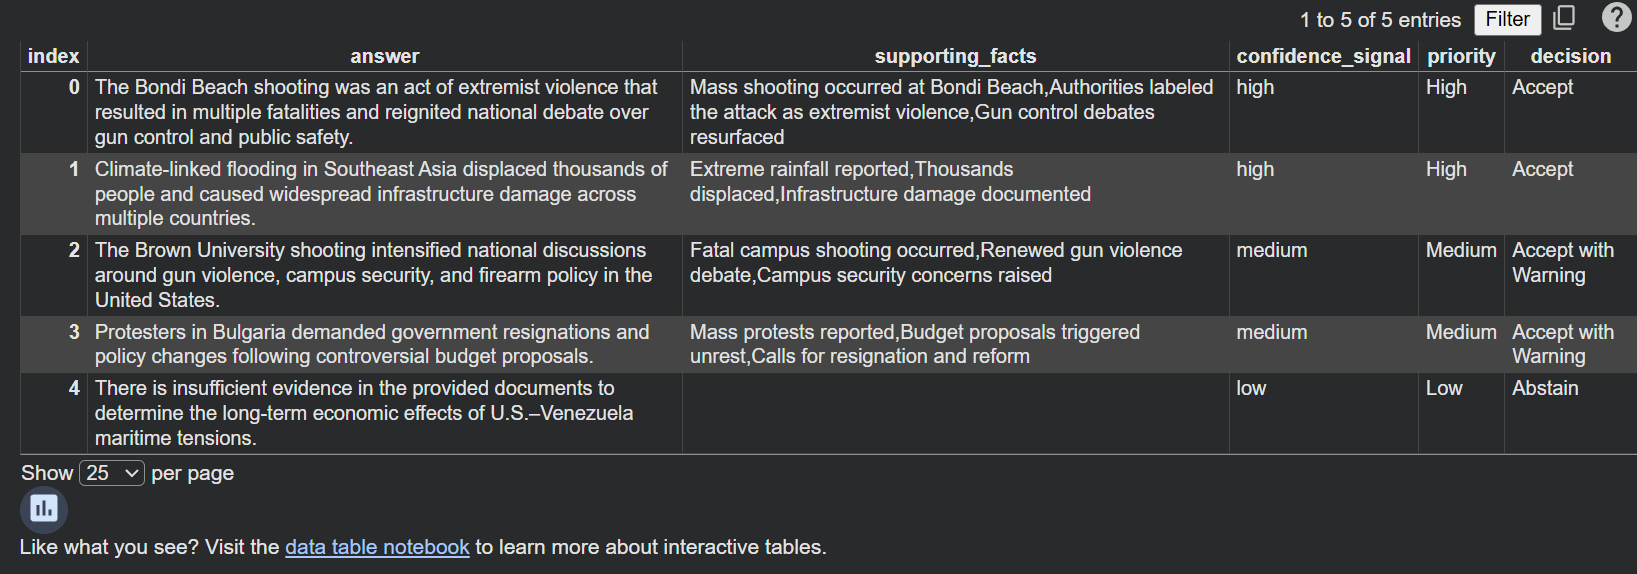

### Step 6 Screenshot

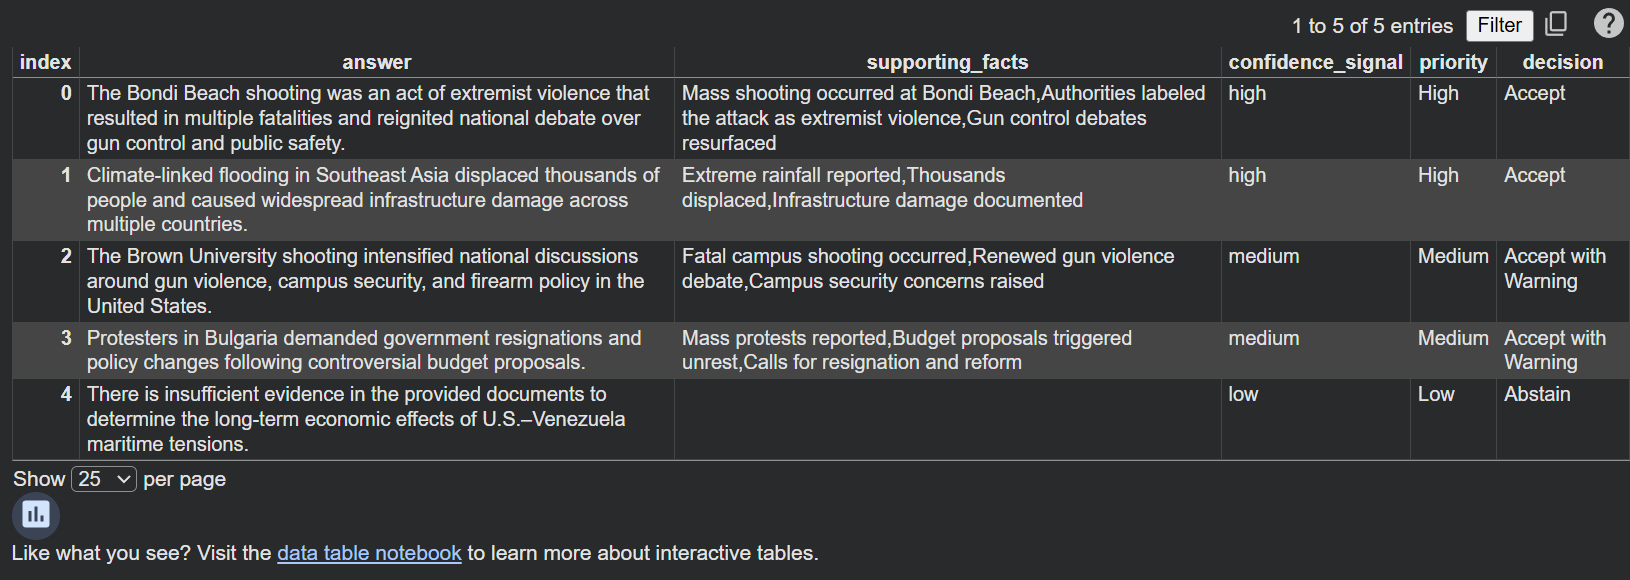

In [37]:
# --------------------------------------------------
# Step 6: Inline Screenshots per Step
# --------------------------------------------------

from IPython.display import display, Image, Markdown
import os

# Define screenshot paths (stored under '/content/screenshots/')
screenshots = {
    "Step 1": "/content/screenshots/Step 1.png",
    "Step 3": "/content/screenshots/Step 3.png",
    "Step 4": "/content/screenshots/Step 4.png",
    "Step 5": "/content/screenshots/Step 5.png",
    "Step 6": "/content/screenshots/Step 6.png",
}

# Display each screenshot under its corresponding step
for step, path in screenshots.items():
    display(Markdown(f"### {step} Screenshot"))
    if os.path.exists(path):
        display(Image(filename=path))
    else:
        display(Markdown(f"*Screenshot for {step} not found at {path}*"))

✅ **Why Step 6 Matters**

- Embeds **visual proof** of pipeline execution.

- Makes the notebook **easy to review** for portfolio evaluators.

- Ensures **each step is documented** for reproducibility.

- Combines **data, reasoning, and outputs** in a single, clean workflow.

# Step 7: Summary, Notes, and Next Steps

**Purpose**

- Summarize the **full multi-step reasoning pipeline**.

- Highlight **key lessons and outputs**.

- Provide guidance for **future use and expansion**.

In [38]:
from IPython.display import display, Markdown

display(Markdown("""
# Step 7: Notebook Summary & Next Steps

## Summary of Pipeline

1. **Step 1 — Sample Queries & Documents**
   - Loaded recent news-driven queries
   - Associated supporting reference documents

2. **Step 2 — Gemini Query Interface**
   - Set simulation mode
   - Defined deterministic interface with confidence signals

3. **Step 3 — Prompt Construction & Candidate Answers**
   - Built structured prompts for each query
   - Generated simulated answers with supporting facts

4. **Step 4 — Rule-Based Validation & Priority Classification**
   - Applied abstention and confidence rules
   - Assigned priority levels (High / Medium / Low)
   - Made accept/abstain decisions

5. **Step 5 — Optional Live Mode / Simulation Review**
   - Enabled toggle between simulation and live API mode
   - Refreshed final structured outputs

6. **Step 6 — Visualization & Inline Screenshots**
   - Displayed results in a DataFrame
   - Embedded step-by-step screenshots for clarity

## Key Notes

- **Simulation mode ensures deterministic, quota-safe execution**
- Confidence signals guide **triaging and abstention**
- The notebook demonstrates **multi-step reasoning and structured LLM pipelines**
- Screenshots make the workflow **portfolio-ready and reproducible**

## Next Steps / Usage

- Set `LIVE_MODE = True` to run live Gemini API queries
- Extend queries and reference documents for broader testing
- Integrate pipeline into **research, reporting, or briefing workflows**
- Consider adding **additional rule-based checks** for domain-specific priorities
"""))


# Step 7: Notebook Summary & Next Steps

## Summary of Pipeline

1. **Step 1 — Sample Queries & Documents**
   - Loaded recent news-driven queries
   - Associated supporting reference documents

2. **Step 2 — Gemini Query Interface**
   - Set simulation mode
   - Defined deterministic interface with confidence signals

3. **Step 3 — Prompt Construction & Candidate Answers**
   - Built structured prompts for each query
   - Generated simulated answers with supporting facts

4. **Step 4 — Rule-Based Validation & Priority Classification**
   - Applied abstention and confidence rules
   - Assigned priority levels (High / Medium / Low)
   - Made accept/abstain decisions

5. **Step 5 — Optional Live Mode / Simulation Review**
   - Enabled toggle between simulation and live API mode
   - Refreshed final structured outputs

6. **Step 6 — Visualization & Inline Screenshots**
   - Displayed results in a DataFrame
   - Embedded step-by-step screenshots for clarity

## Key Notes

- **Simulation mode ensures deterministic, quota-safe execution**
- Confidence signals guide **triaging and abstention**
- The notebook demonstrates **multi-step reasoning and structured LLM pipelines**
- Screenshots make the workflow **portfolio-ready and reproducible**

## Next Steps / Usage

- Set `LIVE_MODE = True` to run live Gemini API queries
- Extend queries and reference documents for broader testing
- Integrate pipeline into **research, reporting, or briefing workflows**
- Consider adding **additional rule-based checks** for domain-specific priorities
